In [14]:
import os
from pathlib import Path

from PIL import Image
import matplotlib.pyplot as plt


from torchinfo import summary
import torch

import numpy as np

device = (
    torch.device("cuda") if torch.cuda.is_available()
    else torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cpu")
)

print("Using device:", device)

from deghost.model import DeGhostUNet

Using device: mps


In [9]:
cfg_model = {
  "base": 32,
  "in_ch":  1,
  "out_ch": 1,
  "levels": 5,
  "max_groups": 8,
  "mid_blocks": 4,
  "pad_to_multiple": True,
}

checkpoint_file = Path("../checkpoints/deghost_cnn_lvl-5_b-32_2026-02-19_14:37.pt")

assert checkpoint_file.exists()

In [10]:
# --- Model ---
model = DeGhostUNet(**cfg_model)
checkpoint = torch.load(checkpoint_file, map_location=device)

model.load_state_dict(checkpoint["model"])
model.to(device)
model.eval()

print("Checkpoint loaded.")
summary(model,input_size=(1,1,256,256))

Checkpoint loaded.


Layer (type:depth-idx)                   Output Shape              Param #
DeGhostUNet                              [1, 1, 256, 256]          --
├─ModuleList: 1-9                        --                        (recursive)
│    └─ResBlock: 2-1                     [1, 32, 256, 256]         --
│    │    └─Conv2d: 3-1                  [1, 32, 256, 256]         320
│    │    └─GroupNorm: 3-2               [1, 32, 256, 256]         64
│    │    └─SiLU: 3-3                    [1, 32, 256, 256]         --
│    │    └─Conv2d: 3-4                  [1, 32, 256, 256]         9,248
│    │    └─GroupNorm: 3-5               [1, 32, 256, 256]         64
│    │    └─Conv2d: 3-6                  [1, 32, 256, 256]         64
│    │    └─SiLU: 3-7                    [1, 32, 256, 256]         --
├─ModuleList: 1-8                        --                        (recursive)
│    └─Downsample: 2-2                   [1, 64, 128, 128]         --
│    │    └─Conv2d: 3-8                  [1, 64, 128, 128]     

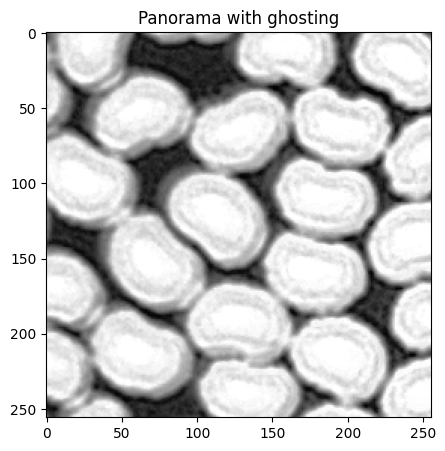

In [19]:
file_path  = Path("../data/245_004.adj.test.tif")
# --- Load image ---
image_np = np.array(Image.open(file_path).convert("L"))

plt.figure(figsize=(15, 5))
plt.imshow(image_np, cmap="gray")
plt.title("Panorama with ghosting")


# --- Normalize to [0,1] float32 ---
image_np = np.array(image_np, dtype=np.float32) / 255.0

# --- Convert to tensor with shape (B, C, H, W) ---
image_tensor = torch.from_numpy(image_np).unsqueeze(0).unsqueeze(0)
# x0 = 3750
# y0 = 80

# w, h = 512, 1024


# crop = image_np[y0:y0+h, x0:x0+w]
# plt.figure(figsize=(10, 10))
# plt.imshow(crop, cmap="gray")
# plt.title("Crop with ghosting")

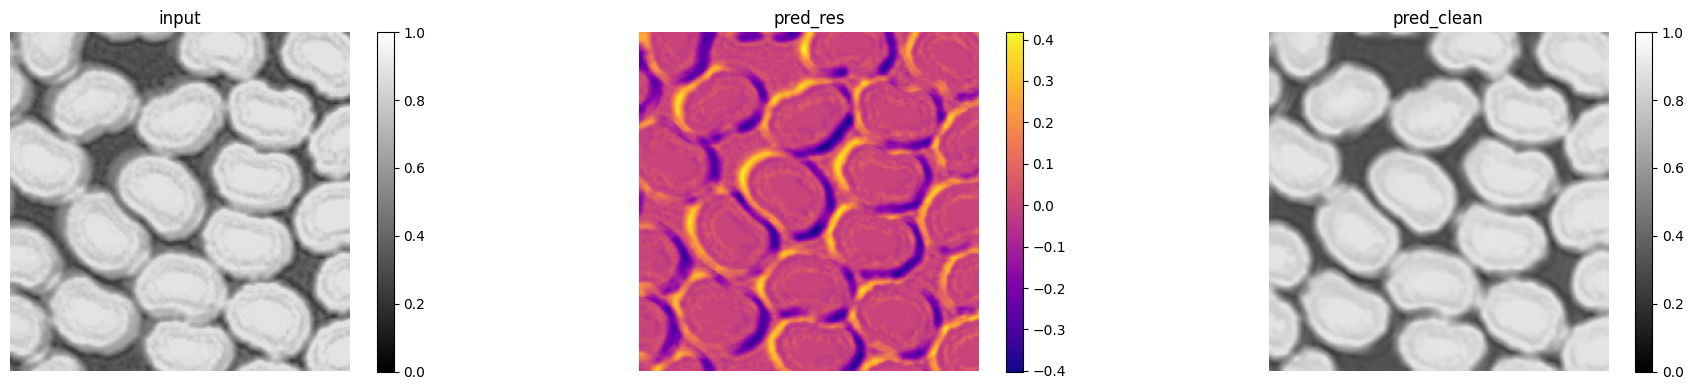

In [21]:
model.eval().to(device)
with torch.no_grad():
    ghost_d = image_tensor.to(device, non_blocking=True)
    pred_res = model(ghost_d)
    pred_clean = (ghost_d + pred_res).clamp(0, 1)

pred_clean_np = pred_clean.squeeze().squeeze().cpu().numpy()
pred_res_np = pred_res.squeeze().squeeze().cpu().numpy()

fig, axs = plt.subplots(1, 3, figsize=(20,4))


# --- Input ---
im0 = axs[0].imshow(image_np, cmap="gray", vmin=0, vmax=1)
axs[0].set_title("input")
fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

# --- Residual ---
im1 = axs[1].imshow(pred_res_np, cmap="plasma")
axs[1].set_title("pred_res")
fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

# --- Clean ---
im2 = axs[2].imshow(pred_clean_np, cmap="gray", vmin=0, vmax=1)
axs[2].set_title("pred_clean")
fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

for ax in axs:
    ax.axis("off")

plt.tight_layout()
plt.show()